### Support Vector Machine Classifier

#### A support vector machine (SVM) is known as a maximum margin classifier. The objective is to identify hyperplanes that maximize the margin between classes.

<img align="center" style="float: l;" src="./images/svm.png" width="450px">

### Regularization Parameter C
#### The C parameter tells the SVM optimization how much you want to avoid misclassifying each training example. The larger C is the C value, the less the final training error will be. But if you increase C too much you risk losing the generalization properties of the classifier as it will try to fit all the training points. For large values of C, the optimization will choose a smaller-margin hyperplane if that hyperplane does a better job of getting all the training points classified correctly. Conversely, a very small value of C will cause the optimizer to look for a larger-margin separating hyperplane, even if that hyperplane misclassifies more points. For very tiny values of C, you should get misclassified examples, often even if your training data is linearly separable. The idea is to find a C that keeps the training error small, but also generalizes well.

<img align="center" style="float: l;" src="./images/soft-margin.png" width="450px">

### Non-Linear Separable  Data

#### There are instances when data is not linear separable. In this case we can use kernels to perform an expansion of dimensional space to improve our ability to separate classes. 

![title](./images/RBF.png)

                                           
### Environment Setup

In [1]:
import re
import nltk
import numpy as np
import pandas as pd
import pickle as pkl
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, auc
from nltk.corpus import stopwords
%matplotlib inline 
import matplotlib.pyplot as plt

#### We will plot graphs with a plotting function for all the SVM models we create.

In [2]:
def plotgraph(figure, results, C):
    plt.figure(figure)
    for index, row in results.iterrows():
        name = row['name']
        acc = row['accuracy']
        tracc = [item[0] for item in acc]
        tstacc = [item[1] for item in acc]
        trainAcc = plt.plot(C, tracc, label=name + ' - Training Error', ls='dashed', linewidth=2)
        color = trainAcc[0].get_color()
        testACC = plt.plot(C, tstacc, label=name + ' - Testing Error', color=color, linewidth=2)
    params = {'legend.fontsize': 8}
    plt.rcParams.update(params)
    axis = plt.gca()
    axis.set_ylim([0.0, 1.05])
    plt.title("SVM Accuracy versus Slack")
    plt.ylabel("Accuracy")
    plt.xlabel("C")
    plt.legend(loc="best")
    plt.show(block=False)

### Syntatic NLP Processing

#### We will define some Python functions that will perform some syntatic work on our corpus. 

In [3]:
def tokenize(text):
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = [ token for token in tokens if re.search('(^[a-zA-Z]+$)', token) ]
    return filtered_tokens

cachedStopWords = stopwords.words("english") + ['year', 'old', 'man', 'woman', 'ap', 'am', 'pm', 'portable', 'pa', 'lat', 'admitting', 'diagnosis', 'lateral']


### Retrieving our Corpus

#### Let's pull in our corpus that we had serialized out to disk.  

In [4]:
file = open('differential-corpus.pkl','rb')
corpus = pkl.load(file)
file.close()
corpusList = list(corpus.values())
labels = list(corpus.keys())

### Generate Document-Term Frequency Counts

#### In this step we tokenize our text and remove stop words in addition to generating our frequency counts.

#### 1) How many documents are we working with and how many features (unigrams & bigrams)?

#### 2) Can you figure out what max_df and min_df is doing to our feature count?

In [5]:
cv = CountVectorizer(lowercase=True, max_df=0.80, max_features=None, min_df=0.033,
                     ngram_range=(1, 2), preprocessor=None, stop_words=cachedStopWords,
                     strip_accents=None, tokenizer=tokenize, vocabulary=None)
X = cv.fit_transform(corpusList)
print(X.shape)
print()
lexicon = cv.get_feature_names()
print (lexicon)
print()

(1500, 773)

['abd', 'abdomen', 'abdomen contrast', 'abdomen pelvis', 'abdominal', 'abnormalities', 'acquired', 'acute', 'acute sob', 'addition', 'adjacent', 'administered', 'administration', 'adrenal', 'adrenal glands', 'air', 'air space', 'airspace', 'allowing', 'along', 'also', 'also noted', 'although', 'alveolar', 'amount', 'amt', 'amt final', 'amt underlying', 'angle', 'anterior', 'aorta', 'aortic', 'aortic stenosis', 'apex', 'apical', 'apices', 'appear', 'appearance', 'appears', 'approximately', 'approximately cm', 'area', 'areas', 'arrest', 'arteries', 'artery', 'ascites', 'aspect', 'aspiration', 'assess', 'associated', 'atelectasis', 'atelectasis left', 'atrial', 'atrium', 'attenuation', 'available', 'axial', 'axial images', 'axillary', 'base', 'bases', 'basilar', 'bibasilar', 'bilateral', 'bilateral pleural', 'bilateral pulmonary', 'bilaterally', 'bladder', 'bleed', 'blunting', 'bone', 'bone windows', 'bowel', 'breath', 'c', 'ca', 'cabg', 'cad', 'cad chf', 'calcification', 'ca

### Construct our Classes

#### We need to assign a class for each classification. We typically assign numeric values to classes.

In [6]:
Y = []
for key in corpus:        
    if (key.startswith('COPD') or key.startswith('CHF')):
        Y.append(0)
    elif (key.startswith('PNA')):
        Y.append(1)
Y = np.array(Y)

### Let's Run It!

#### We will generate Linear SVM models and evaluate the modes using 10-fold cross-validation.

In [7]:
results = pd.DataFrame(columns=('name', 'accuracy'))
model = 0
acc = []
cont = []
kf = KFold(n_splits=10, shuffle=True)
C = [2, 1, 0.1, 0.05, 0.01]
for c in range(len(C)):
    fold = 1
    truth = []
    svm_prediction = []
    print("model ", model, ": SVM C = " + str(C[c]))
    test_count = 0
    svm = SVC(C=C[c], kernel='linear')
    for train_idx, test_idx in kf.split(X):
        trainX = X[train_idx]
        trainY = Y[train_idx]
        testX = X[test_idx]
        testY = Y[test_idx]
        truth.append(testY)
        svm.fit(trainX, trainY)
        Y_hat = svm.predict(testX)
        svm_prediction.append(Y_hat)
        print("   Fold %d accuracy: %.2f %%" % (fold, ((np.sum(Y_hat == testY)/len(testY)) * 100.0)))                        
        fold += 1
    truth = np.concatenate(truth, axis=0)    
    svm_prediction = np.concatenate(svm_prediction, axis=0)
    test_results = np.sum(svm_prediction == truth)/len(truth)
    print("     Overall test accuracy: %.2f %%" % (test_results * 100))  
    svm = svm.fit(X, Y)
    Y_hat = svm.predict(X)
    train_results = np.sum(Y_hat == Y)/len(Y)
    print("     Overall training accuracy: %.2f %%" % (train_results * 100.0))  
    acc.append([train_results, test_results])   
    cont.append([truth, svm_prediction])
    model += 1
results = results.append({'name': 'Linear SVM', 'accuracy' : acc}, ignore_index=True)  


model  0 : SVM C = 2
   Fold 1 accuracy: 95.33 %
   Fold 2 accuracy: 96.67 %
   Fold 3 accuracy: 98.00 %
   Fold 4 accuracy: 94.00 %
   Fold 5 accuracy: 92.67 %
   Fold 6 accuracy: 93.33 %
   Fold 7 accuracy: 97.33 %
   Fold 8 accuracy: 98.00 %
   Fold 9 accuracy: 96.00 %
   Fold 10 accuracy: 98.67 %
     Overall test accuracy: 96.00 %
     Overall training accuracy: 100.00 %
model  1 : SVM C = 1
   Fold 1 accuracy: 97.33 %
   Fold 2 accuracy: 98.00 %
   Fold 3 accuracy: 96.00 %
   Fold 4 accuracy: 94.67 %
   Fold 5 accuracy: 96.00 %
   Fold 6 accuracy: 94.67 %
   Fold 7 accuracy: 95.33 %
   Fold 8 accuracy: 93.33 %
   Fold 9 accuracy: 93.33 %
   Fold 10 accuracy: 97.33 %
     Overall test accuracy: 95.60 %
     Overall training accuracy: 100.00 %
model  2 : SVM C = 0.1
   Fold 1 accuracy: 94.67 %
   Fold 2 accuracy: 96.67 %
   Fold 3 accuracy: 93.33 %
   Fold 4 accuracy: 98.00 %
   Fold 5 accuracy: 98.67 %
   Fold 6 accuracy: 94.67 %
   Fold 7 accuracy: 97.33 %
   Fold 8 accuracy: 96.

#### Let's look at our linear SVM models.

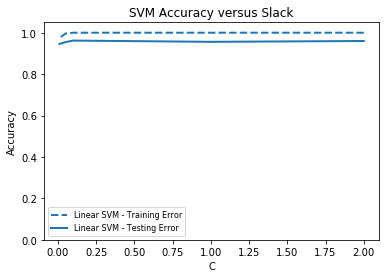

In [8]:
plotgraph(1, results, C)

#### Now we will generate some polynomial kernal SVM models and evaluate the modes using 10-fold cross-validation.

In [9]:
results = pd.DataFrame(columns=('name', 'accuracy'))
kf = KFold(n_splits=10, shuffle=True)
C = [3, 1, 0.5, 0.1]
coef = [5, 2, 1]
degree = [2, 3]
for d in range(len(degree)):
    for r in range(len(coef)):
        acc = []
        name = "SVM Poly=%d Coef=%d" % (degree[d], coef[r])        
        for c in range(len(C)):
            fold = 1
            truth = []
            svm_prediction = []
            print("model %d: SVM Poly=%d Coef=%d C=%.2f" % (model, degree[d], coef[r], C[c]))       
            test_count = 0
            svm = SVC(C=C[c], kernel='poly', degree=degree[d], coef0=coef[r])
            for train_idx, test_idx in kf.split(X):
                trainX = X[train_idx]
                trainY = Y[train_idx]
                testX = X[test_idx]
                testY = Y[test_idx]
                truth.append(testY)
                svm.fit(trainX, trainY)
                Y_hat = svm.predict(testX)
                svm_prediction.append(Y_hat)
                print("   Fold %d accuracy: %.2f %%" % (fold, ((np.sum(Y_hat == testY)/len(testY)) * 100.0)))                        
                fold += 1
            truth = np.concatenate(truth, axis=0)    
            svm_prediction = np.concatenate(svm_prediction, axis=0)
            test_results = np.sum(svm_prediction == truth)/len(truth)
            print("     Overall test accuracy: %.2f %%" % (test_results * 100))  
            svm = svm.fit(X, Y)
            Y_hat = svm.predict(X)
            train_results = np.sum(Y_hat == Y)/len(Y)
            print("     Overall training accuracy: %.2f %%" % (train_results * 100.0))  
            acc.append([train_results, test_results])   
            cont.append([truth, svm_prediction])
            model += 1
        results = results.append({'name': name, 'accuracy' : acc}, ignore_index=True)  

model 5: SVM Poly=2 Coef=5 C=3.00
   Fold 1 accuracy: 96.00 %
   Fold 2 accuracy: 96.67 %
   Fold 3 accuracy: 95.33 %
   Fold 4 accuracy: 98.00 %
   Fold 5 accuracy: 96.00 %
   Fold 6 accuracy: 94.67 %
   Fold 7 accuracy: 95.33 %
   Fold 8 accuracy: 96.67 %
   Fold 9 accuracy: 94.67 %
   Fold 10 accuracy: 95.33 %
     Overall test accuracy: 95.87 %
     Overall training accuracy: 99.40 %
model 6: SVM Poly=2 Coef=5 C=1.00
   Fold 1 accuracy: 96.00 %
   Fold 2 accuracy: 96.00 %
   Fold 3 accuracy: 94.67 %
   Fold 4 accuracy: 96.67 %
   Fold 5 accuracy: 96.67 %
   Fold 6 accuracy: 94.67 %
   Fold 7 accuracy: 94.00 %
   Fold 8 accuracy: 96.00 %
   Fold 9 accuracy: 98.00 %
   Fold 10 accuracy: 94.67 %
     Overall test accuracy: 95.73 %
     Overall training accuracy: 98.00 %
model 7: SVM Poly=2 Coef=5 C=0.50
   Fold 1 accuracy: 96.00 %
   Fold 2 accuracy: 94.00 %
   Fold 3 accuracy: 94.67 %
   Fold 4 accuracy: 92.00 %
   Fold 5 accuracy: 94.00 %
   Fold 6 accuracy: 91.33 %
   Fold 7 accura

   Fold 1 accuracy: 96.67 %
   Fold 2 accuracy: 94.67 %
   Fold 3 accuracy: 97.33 %
   Fold 4 accuracy: 94.67 %
   Fold 5 accuracy: 92.00 %
   Fold 6 accuracy: 94.67 %
   Fold 7 accuracy: 96.00 %
   Fold 8 accuracy: 91.33 %
   Fold 9 accuracy: 96.00 %
   Fold 10 accuracy: 92.00 %
     Overall test accuracy: 94.53 %
     Overall training accuracy: 96.93 %
model 27: SVM Poly=3 Coef=1 C=0.50
   Fold 1 accuracy: 93.33 %
   Fold 2 accuracy: 93.33 %
   Fold 3 accuracy: 94.00 %
   Fold 4 accuracy: 88.67 %
   Fold 5 accuracy: 94.00 %
   Fold 6 accuracy: 92.00 %
   Fold 7 accuracy: 92.67 %
   Fold 8 accuracy: 96.00 %
   Fold 9 accuracy: 94.67 %
   Fold 10 accuracy: 89.33 %
     Overall test accuracy: 92.80 %
     Overall training accuracy: 95.33 %
model 28: SVM Poly=3 Coef=1 C=0.10
   Fold 1 accuracy: 76.00 %
   Fold 2 accuracy: 84.67 %
   Fold 3 accuracy: 78.67 %
   Fold 4 accuracy: 80.67 %
   Fold 5 accuracy: 88.00 %
   Fold 6 accuracy: 81.33 %
   Fold 7 accuracy: 85.33 %
   Fold 8 accuracy: 

#### Let's plot our polynomial kernel SVM models.

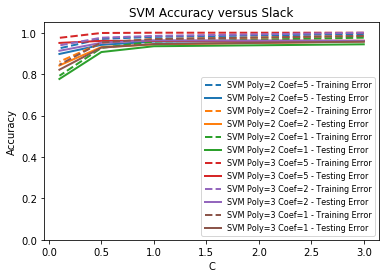

In [10]:
plotgraph(2, results, C)

#### Now we will generate RBF kernal SVM models and evaluate the modes using 10-fold cross-validation.

In [11]:
results = pd.DataFrame(columns=('name', 'accuracy'))
kf = KFold(n_splits=10, shuffle=True)
C = [5, 1, 0.5, 0.1]
gamma = [0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]  
for g in range(len(gamma)):
    acc = []
    name = "SVM RBF Gamma=%.3f" % (gamma[g])     
    for c in range(len(C)):
        fold = 1
        truth = []
        svm_prediction = []
        print("model %d: SVM RBF Gamma=%.3f C=%.2f" % (model, gamma[g], C[c]))        
        test_count = 0
        svm = SVC(C=C[c], kernel='rbf', gamma=gamma[g])
        for train_idx, test_idx in kf.split(X):
            trainX = X[train_idx]
            trainY = Y[train_idx]
            testX = X[test_idx]
            testY = Y[test_idx]
            truth.append(testY)
            svm.fit(trainX, trainY)
            Y_hat = svm.predict(testX)
            svm_prediction.append(Y_hat)
            print("   Fold %d accuracy: %.2f %%" % (fold, ((np.sum(Y_hat == testY)/len(testY)) * 100.0)))                        
            fold += 1
        truth = np.concatenate(truth, axis=0)    
        svm_prediction = np.concatenate(svm_prediction, axis=0)
        test_results = np.sum(svm_prediction == truth)/len(truth)
        print("     Overall test accuracy: %.2f %%" % (test_results * 100))  
        svm = svm.fit(X, Y)
        Y_hat = svm.predict(X)
        train_results = np.sum(Y_hat == Y)/len(Y)
        print("     Overall training accuracy: %.2f %%" % (train_results * 100.0))  
        acc.append([train_results, test_results])   
        cont.append([truth, svm_prediction])
        model += 1
    results = results.append({'name': name, 'accuracy' : acc}, ignore_index=True)  

model 29: SVM RBF Gamma=0.001 C=5.00
   Fold 1 accuracy: 95.33 %
   Fold 2 accuracy: 94.00 %
   Fold 3 accuracy: 93.33 %
   Fold 4 accuracy: 94.67 %
   Fold 5 accuracy: 88.67 %
   Fold 6 accuracy: 92.00 %
   Fold 7 accuracy: 93.33 %
   Fold 8 accuracy: 95.33 %
   Fold 9 accuracy: 94.67 %
   Fold 10 accuracy: 97.33 %
     Overall test accuracy: 93.87 %
     Overall training accuracy: 96.67 %
model 30: SVM RBF Gamma=0.001 C=1.00
   Fold 1 accuracy: 80.00 %
   Fold 2 accuracy: 90.67 %
   Fold 3 accuracy: 90.67 %
   Fold 4 accuracy: 86.67 %
   Fold 5 accuracy: 89.33 %
   Fold 6 accuracy: 86.00 %
   Fold 7 accuracy: 91.33 %
   Fold 8 accuracy: 90.00 %
   Fold 9 accuracy: 88.67 %
   Fold 10 accuracy: 90.00 %
     Overall test accuracy: 88.33 %
     Overall training accuracy: 90.40 %
model 31: SVM RBF Gamma=0.001 C=0.50
   Fold 1 accuracy: 85.33 %
   Fold 2 accuracy: 82.00 %
   Fold 3 accuracy: 83.33 %
   Fold 4 accuracy: 80.67 %
   Fold 5 accuracy: 79.33 %
   Fold 6 accuracy: 83.33 %
   Fold

     Overall training accuracy: 100.00 %
model 50: SVM RBF Gamma=0.100 C=1.00
   Fold 1 accuracy: 75.33 %
   Fold 2 accuracy: 66.67 %
   Fold 3 accuracy: 78.67 %
   Fold 4 accuracy: 78.67 %
   Fold 5 accuracy: 80.00 %
   Fold 6 accuracy: 74.67 %
   Fold 7 accuracy: 70.67 %
   Fold 8 accuracy: 78.67 %
   Fold 9 accuracy: 81.33 %
   Fold 10 accuracy: 76.67 %
     Overall test accuracy: 76.13 %
     Overall training accuracy: 100.00 %
model 51: SVM RBF Gamma=0.100 C=0.50
   Fold 1 accuracy: 69.33 %
   Fold 2 accuracy: 74.67 %
   Fold 3 accuracy: 78.67 %
   Fold 4 accuracy: 74.67 %
   Fold 5 accuracy: 78.00 %
   Fold 6 accuracy: 80.00 %
   Fold 7 accuracy: 66.67 %
   Fold 8 accuracy: 65.33 %
   Fold 9 accuracy: 80.00 %
   Fold 10 accuracy: 68.00 %
     Overall test accuracy: 73.53 %
     Overall training accuracy: 100.00 %
model 52: SVM RBF Gamma=0.100 C=0.10
   Fold 1 accuracy: 75.33 %
   Fold 2 accuracy: 75.33 %
   Fold 3 accuracy: 62.00 %
   Fold 4 accuracy: 64.67 %
   Fold 5 accuracy: 

#### Let's plot our RBF kernel SVM models.

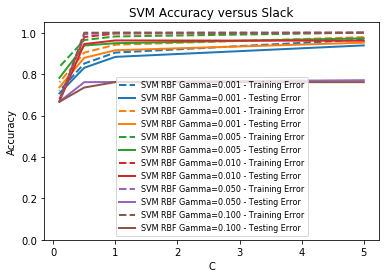

In [12]:
plotgraph(3, results, C)

### Contingency Tables

#### Let's look at the contingency tables

#### 1) Can you calculate the Sensitivity, Specificity, PPV, NPV? 

In [13]:
model = input("Enter Best Model: ")
best = cont[int(model)]
svm_ct = pd.crosstab(best[1], best[0], margins=True)
svm_ct.columns = ["Other", "PNA", "Total"]
svm_ct.index = ["Other", "PNA", "Total"]
print()
print("SVM")
print(svm_ct)
print()


Enter Best Model: 3

SVM
       Other  PNA  Total
Other    984   52   1036
PNA       16  448    464
Total   1000  500   1500



### Evaluation Statistics

#### We will calculate some test statistics for our classifiers

In [14]:
Sens = svm_ct.iloc[1][1]/svm_ct.iloc[2][1]
Spec = svm_ct.iloc[0][0]/svm_ct.iloc[2][0]
PPV = svm_ct.iloc[1][1]/svm_ct.iloc[1][2]
NPV = svm_ct.iloc[0][0]/svm_ct.iloc[0][2]
ACC = (svm_ct.iloc[0][0] + svm_ct.iloc[1][1]) / svm_ct.iloc[2][2]
print("SVM: Sensitivity: %.5f Specificity: %.5f PPV: %.5f NPV: %.5f Accuracy: %.5f" % (Sens, Spec, PPV, NPV, ACC))                                                                                      

SVM: Sensitivity: 0.89600 Specificity: 0.98400 PPV: 0.96552 NPV: 0.94981 Accuracy: 0.95467


### ROC Curve

#### 1) So which classifier do you think is better?

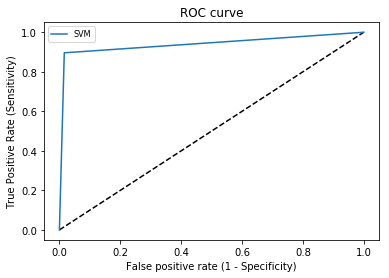

AUC =  0.94


In [15]:
svm_fpr, svm_tpr, svm_thresholds = roc_curve(best[0], best[1], pos_label=1)
roc_auc = auc(svm_fpr, svm_tpr)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(svm_fpr, svm_tpr, label='SVM')
plt.xlabel('False positive rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
print("AUC = ", roc_auc)